## First Attempt

This is slightly wrong but I still don't know why the objective function can be negative

In [49]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [50]:
stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 48, 'station 5': 9}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# fill over, under stations
for station in stations:
    if start_levels[station] >= optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] <= optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # number of time steps
K = 2 # number of trucks
L = 3 # number of bikes that can be moved in one time step

In [51]:
model = gp.Model("bike_rebalancing")
# N = G.nodes()
# What is this for??

In [52]:
'''
decision variables: 
x: whether or not truck k is at station s at time t
y: number of bikes available to truck k is at station s at time t
b: number of bikes in truck k at time t
'''
x, y, b = {}, {}, {}

for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s,t,k] = model.addVar(name="x_%s,%s,%s"%(s,t,k), vtype=GRB.BINARY)
            y[s,t,k] = model.addVar(name="y_%s,%s,%s"%(s,t,k), vtype=GRB.INTEGER)
        b[t,k] = model.addVar(name="b_%s,%s"%(t,k), vtype=GRB.INTEGER)

model.update()

In [53]:
# objective function

objective = gp.quicksum((optimal_levels[s] - y[s, T, 1]) for s in under_stations) \
            + gp.quicksum((y[s,T,1] - optimal_levels[s]) for s in over_stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

In [54]:
# constraints

# each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s,t,k] for s in stations) == 1)

# initiate
for s in stations:
    model.addConstr(sum(y[s,1,k] for k in range(1, K+1)) == start_levels[s])

# rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= optimal_levels[s])

# total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s,t,k] for s in stations) + b[t,k] == sum(y[s,1,k] for s in stations) + b[1,k])

# can move only when truck is at station, number of bikes moved is bounded by 
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s,t,k] - y[s,t-1,k] <= L * x[s,t,k])
            model.addConstr(y[s,t-1,k] - y[s,t,k] <= L * x[s,t,k])

# add last constraint later...

In [55]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 325 rows, 220 columns and 1066 nonzeros
Model fingerprint: 0x8427abed
Variable types: 0 continuous, 220 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 72.0000000
Presolve removed 55 rows and 38 columns
Presolve time: 0.00s
Presolved: 270 rows, 182 columns, 770 nonzeros
Variable types: 0 continuous, 182 integer (88 binary)

Root relaxation: objective -1.200000e+01, 184 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0             

## Slight Fix

As you can see, I was getting negative values for the objective function, which is wrong. Introducing deviations seems to fix it...

In [64]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 48, 'station 5': 9}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 7 # Number of time steps
K = 2 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 353 rows, 159 columns and 1234 nonzeros
Model fingerprint: 0x53d596a7
Variable types: 0 continuous, 159 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 111 rows and 16 columns
Presolve time: 0.00s
Presolved: 242 rows, 143 columns, 763 nonzeros
Variable types: 0 continuous, 143 integer (70 binary)
Found heuristic solution: objective 78.0000000
Found heuristic solution: objective 77.0000000

Root relaxation: objective 4.800000e+01, 185 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

## Graphing

Something is still not working right because it seems like trucks are reducing the number of bikes in station 4 just by making trips back to station 4 again and again which doesn't make sense... intuitively, they would have to go to a different station first to drop off the bikes...

Truck 1 path: [(1, 'station 4'), (2, 'station 4'), (3, 'station 4'), (4, 'station 4'), (5, 'station 4'), (6, 'station 4'), (7, 'station 4')]
Truck 2 path: [(1, 'station 4'), (2, 'station 4'), (3, 'station 4'), (4, 'station 4'), (5, 'station 4'), (6, 'station 4'), (7, 'station 4')]


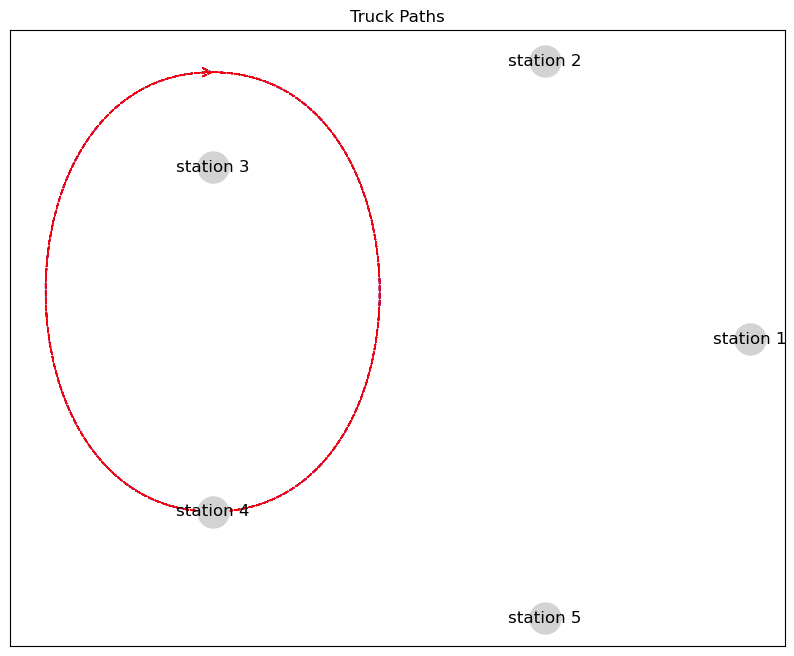

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}
if model.status == GRB.OPTIMAL:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")

# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.1  # You can adjust the radius as needed

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i]
            t2, s2 = path[i + 1]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    #plt.legend()
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)